#Домашнее задание № 5. Сингулярный спектральный анализ.

##Загрузим необходимые данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-27 05:52:04--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip’

1._Лекция_tsml.zip  100%[===================>] 751.03K   813KB/s    in 0.9s    

2025-02-27 05:52:06 (813 KB/s) - ‘1._Лекция_tsml.zip’ saved [769056/769056]



In [3]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [4]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [137]:
series = monthly_boston_armed_robberies_j['Count']
F = series

In [6]:
# вывод графиков
def chart_2(series_1, series_2=None, title=None):
    plt.figure(figsize=(14, 7))
    plt.plot(series_1, label='Временной ряд')
    if series_2 is not None:
        plt.plot(series_2, label=title)
    plt.title('Визуальное сравнение полученного временного ряда')
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

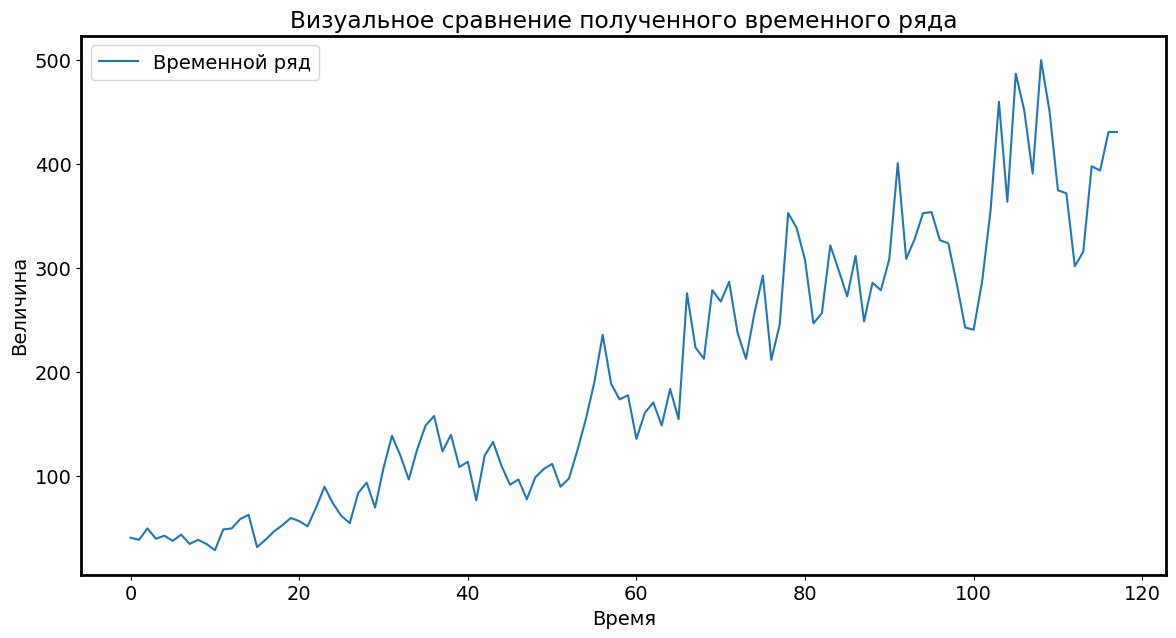

In [138]:
# посмотрим на график
chart_2(F)

##SSA

#1. Разложение

In [9]:
import scipy.linalg
import seaborn as sns

In [48]:
# настройки рисунка
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# установим цветовой цикл по умолчанию
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# маленький 2D-матричный плоттер, без меток x и y
def plot_2d(m, title=''):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [165]:
# функция для матрицы Ханкеля
def embed(TS, window_length):
    # вставим временной ряд в матрицу Ханкеля
    K = len(TS) - window_length + 1
    trajectory_matrix = scipy.linalg.hankel(TS, np.zeros(window_length)).T[:, : K]
    return trajectory_matrix, window_length, K

In [139]:
# посмотрим на размер ряда
len(F)

118

In [140]:
# зададим размер окна
# принимаю, что он совпадает с предполагаемой сезонностью х 3
window_length = 36

In [166]:
# получим матрицу Ханкеля
trajectory_matrix, L, K = embed(F, window_length)
trajectory_matrix[1], L, K

(array([ 39.,  50.,  40.,  43.,  38.,  44.,  35.,  39.,  35.,  29.,  49.,
         50.,  59.,  63.,  32.,  39.,  47.,  53.,  60.,  57.,  52.,  70.,
         90.,  74.,  62.,  55.,  84.,  94.,  70., 108., 139., 120.,  97.,
        126., 149., 158., 124., 140., 109., 114.,  77., 120., 133., 110.,
         92.,  97.,  78.,  99., 107., 112.,  90.,  98., 125., 155., 190.,
        236., 189., 174., 178., 136., 161., 171., 149., 184., 155., 276.,
        224., 213., 279., 268., 287., 238., 213., 257., 293., 212., 246.,
        353., 339., 308., 247., 257., 322.]),
 36,
 83)

In [142]:
# проверим
F[:(len(F)-window_length+2)]

,Count
0,41
1,39
2,50
3,40
4,43
...,...
79,339
80,308
81,247
82,257


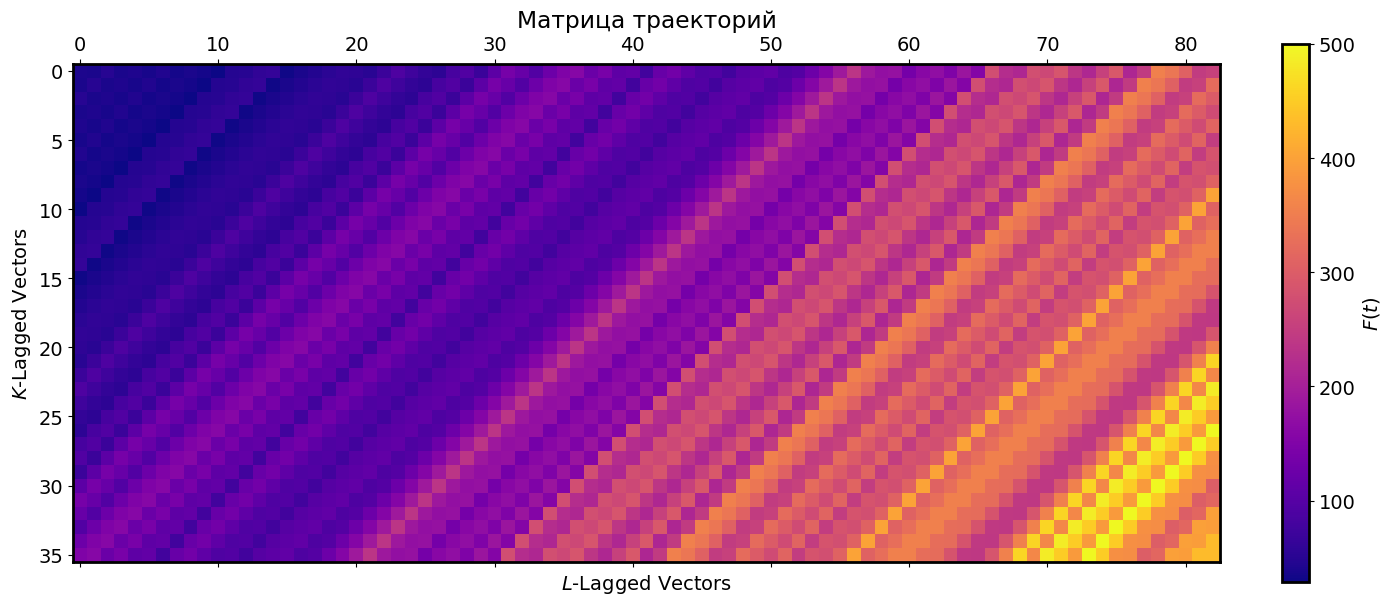

In [143]:
# посмотрим на ее диагональную красоту
ax = plt.matshow(trajectory_matrix)
plt.xlabel('$L$-Lagged Vectors')
plt.ylabel('$K$-Lagged Vectors')
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title('Матрица траекторий');

In [144]:
# разложим матрицу траекторий и сформируем ее элементарные матрицы
def decompose(trajectory_matrix):
    d = np.linalg.matrix_rank(trajectory_matrix)
    U, Sigma, V = np.linalg.svd(trajectory_matrix)
    V = V.T
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

    if not np.allclose(trajectory_matrix, X_elem.sum(axis=0), atol=1e-10):
        print("WARNING: The sum of X's elementary matrices is not equal to X!")

    return d, U, Sigma, V, X_elem

In [87]:
d, U, Sigma, V, X_elem = decompose(trajectory_matrix)

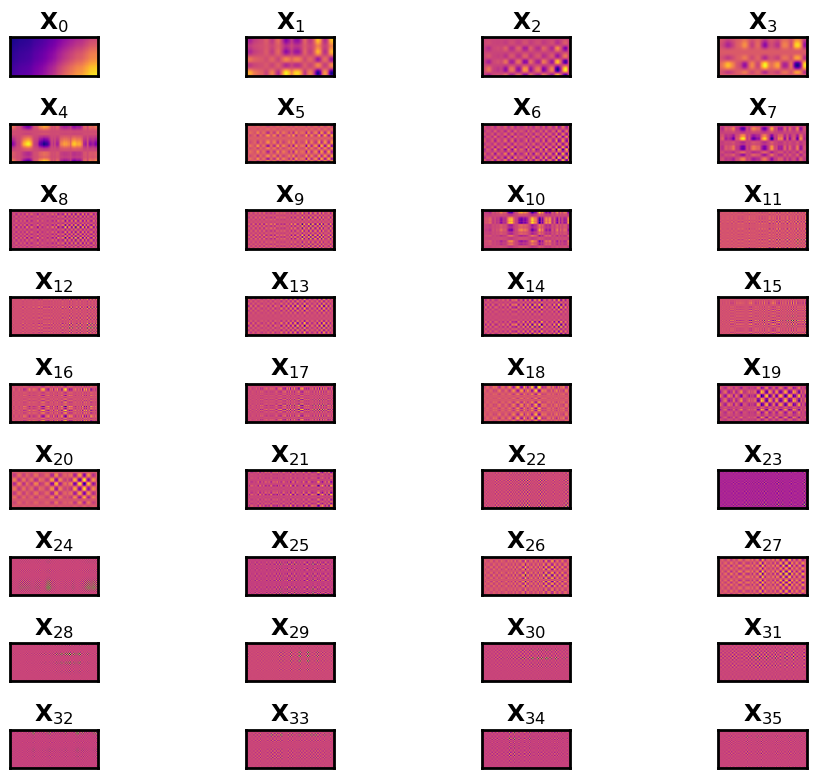

In [145]:
# посмотрим
for i in range(d):
    plt.subplot(9, 4, i+1)
    title = '$\mathbf{X}_{' + str(i) + '}$'
    plot_2d(X_elem[i], title)
plt.tight_layout()

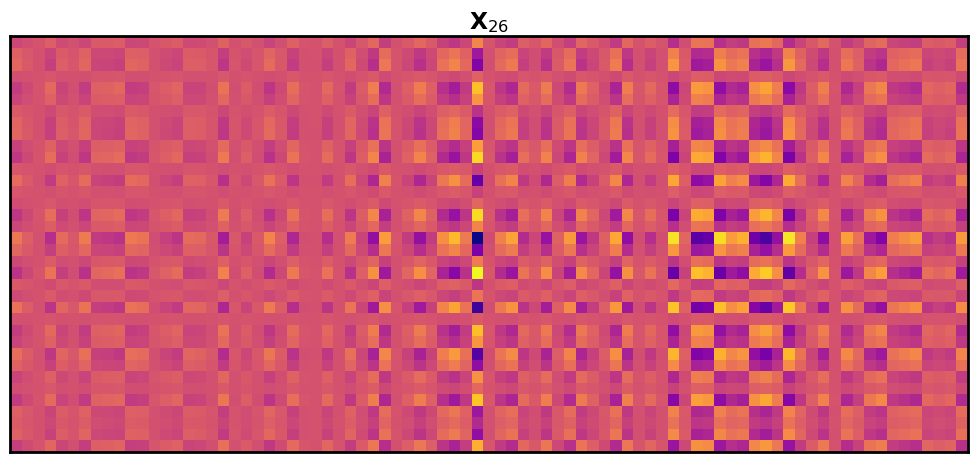

In [146]:
# каждую матрицу можно посмотреть внимательнее
# например,
i = 26
title = '$\mathbf{X}_{' + str(i) + '}$'
plot_2d(X_elem[i], title)
plt.tight_layout()

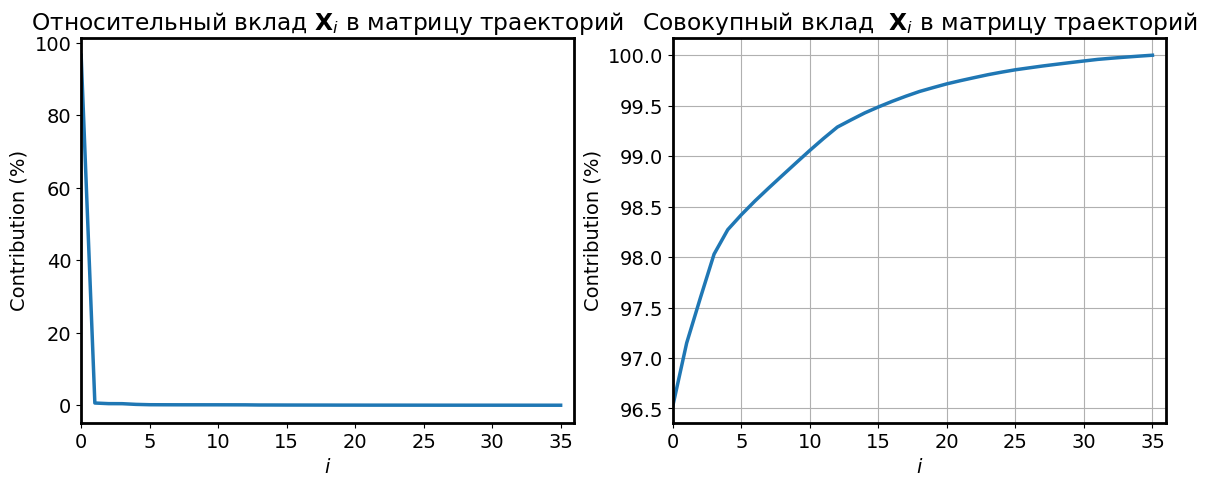

In [147]:
# построим график относительных вкладов и кумулятивных вкладов
# первых n_elements элементарных матриц в матрицу траекторий игрушечного временного ряда
n_elements = window_length
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0, n_elements)
ax[0].set_title('Относительный вклад $\mathbf{X}_i$ в матрицу траекторий')
ax[0].set_xlabel('$i$')
ax[0].set_ylabel('Contribution (%)')
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0, n_elements)
ax[1].set_title('Совокупный вклад  $\mathbf{X}_i$ в матрицу траекторий')
ax[1].set_xlabel('$i$')
ax[1].grid(axis = 'x')
ax[1].grid(axis = 'y')
ax[1].set_ylabel('Contribution (%)');

#2. Реконструкция

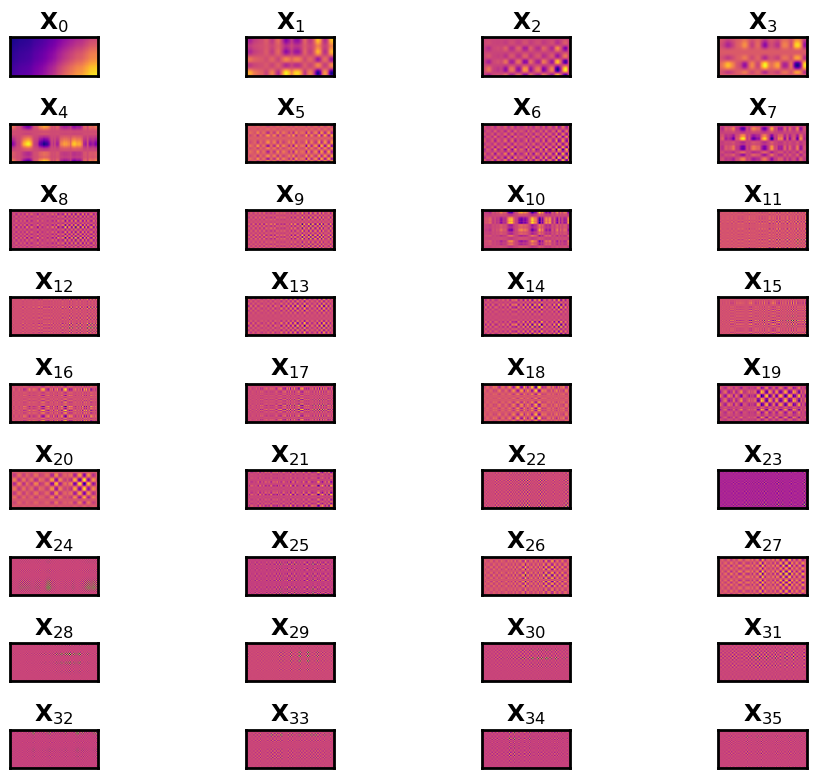

In [149]:
# посмотрим на красиваые графики
# посмотрим
for i in range(d):
    plt.subplot(9, 4, i+1)
    title = '$\mathbf{X}_{' + str(i) + '}$'
    plot_2d(X_elem[i], title)
plt.tight_layout()

In [170]:
# еще одна функция из лекции
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

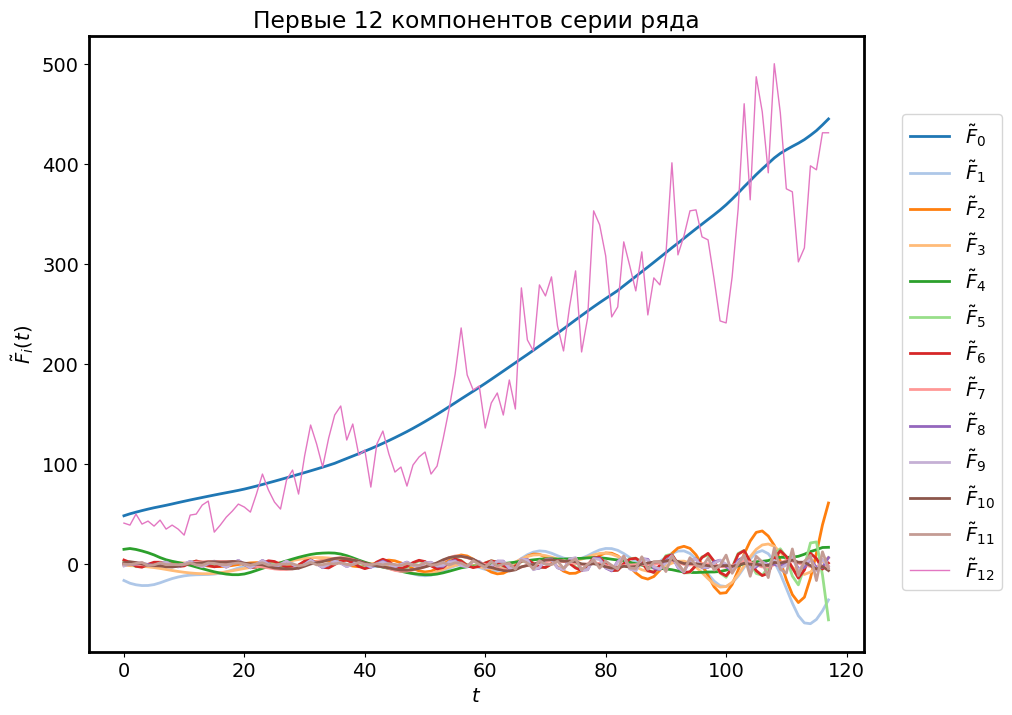

In [171]:
# построим первые n_elements элементарных компонентов
n_elements = 12
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# преобразуем элементарные матрицы непосредственно во временные ряды
t = series
for i in range(n_elements):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(F_i, lw=2)

fig.axes.plot(F, alpha=1, lw=1)
fig.set_xlabel('$t$')
fig.set_ylabel(r'$\tilde{F}_i(t)$')
legend = [r'$\tilde{F}_{%s}$' %i for i in range(n)] + ['$F$']
fig.set_title(f'Первые {n_elements} компонентов серии ряда')
fig.legend(legend, loc=(1.05,0.1));

#3. Разделение и группировка компонентов временных рядов

In [173]:
# построим w-корреляционную матрицу временного ряда
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w),
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]